In [1]:
import matplotlib.pyplot as plt

# YOLO 

En aquesta sessió descobrirem un dels models de l'estat de l'art (SOTA) de l'Aprenentatge Automàtic.

You Only Look Once: Unified, Real-Time Object Detection. [article](https://arxiv.org/pdf/1506.02640) ; [presentació](https://www.youtube.com/watch?v=NM6lrxy0bxs&pp=ygUkeW91IG9ubHkgbG9vayBvbmNlIHByZXNlbnRhdGlvbiBjdnBy)

YOLO (You Only Look Once) és una arquitectura de xarxa neuronal profunda inicialment dissenyada per a la detecció d'objectes en imatges en temps real. A diferència d'altres enfocaments que processen les imatges en diverses etapes com per exemple la família R-CNN. YOLO adopta un enfocament unificat: divideix la imatge en una quadrícula i processa cada cel·la simultàniament per predir les bounding boxes i les classes dels objectes presents. Aquesta integració permet assolir una velocitat notable sense comprometre significativament la precisió. A més, gràcies al seu disseny optimitzat, YOLO ha estat modificada i adaptada per realitzar múltiples tasques relacionades amb la visió per computador. Actualment pot: classificar, detectar, segmentar, seguiment d'objectes a vídeo, seguiment dels moviments del cos.

### YOLO: Una breu història

- **YOLO (You Only Look Once)**, un model popular de detecció d'objectes i segmentació d'imatges, va ser desenvolupat per Joseph Redmon i Ali Farhadi a la Universitat de Washington. Llançat el 2015, YOLO va guanyar ràpidament popularitat per la seva alta velocitat i precisió.
- **YOLOv2**, llançat el 2016, va millorar el model original incorporant _batch normalization_ i  _anchor boxes_.
- **YOLOv3**, llançat el 2018, va millorar encara més el rendiment del model mitjançant un _backbone_ més eficient, múltiples  _anchor boxes_ i agrupació de piràmides espacials (objectes de múltiples mides).
- **YOLOv4** es va llançar el 2020, introduint innovacions com l'augment de dades emprant mosaics, un nou capçal (_head_) de detecció i una nova funció de pèrdua.
- **YOLOv5** va millorar encara més el rendiment del model i va afegir noves funcions com ara l'optimització d'hiperparàmetres, el seguiment d'experiments integrat i l'exportació automàtica a formats d'exportació populars. [**Controvèrsia!!**](https://blog.roboflow.com/yolov4-versus-yolov5/)
- **YOLOv6** va ser de codi obert per [Meituan](https://github.com/meituan/YOLOv6) el 2022 i s'utilitza en molts dels robots de lliurament autònoms de la companyia.
- **YOLOv7** va afegir tasques addicionals, com ara l'estimació de poses (_pose estimation_) al conjunt de dades de punts clau COCO.
- **YOLOv8** Es basa en l'èxit de les versions anteriors, introduint noves funcions i millores per millorar el rendiment, la flexibilitat i l'eficiència. YOLOv8 admet una gamma completa de tasques d'IA de visió, com ara detecció, segmentació, estimació de poses, seguiment i classificació. Aquesta versatilitat permet als usuaris aprofitar les capacitats de YOLOv8 en diferents aplicacions i dominis. --> Propaganda Ultralytics ^^.
- **YOLOv9**, **YOLOv10**, **YOLOv11** : Successives millores en la xarxa, sobretot enfocades a mantenir les seves capacitats reduïnt la seva mida.

Per començar i fer les primeres proves es recomana usar la versió 5, a que té un bon equilibri entre dificultat (complicacions d'ús) i els resultats que podem obtenir.


## Arquitectura

La xarxa té 24 capes convolucionals seguides de 2 capes completament connectades. En lloc dels mòduls inicials utilitzats per [GoogLeNet](https://arxiv.org/pdf/1409.4842), per reduir el mapes d'activació s'utilitzen capes convolucionals 1×1 seguides de capes convolucionals de 3×3.

![YOLO](img/YOLO.png "YOLO")


### Detecció unificada

A diferència de les xarxes que provenen de R-CNN a l'article s'explica:

> Unifiquem els components separats de la detecció d'objectes en una única xarxa neuronal. La nostra xarxa utilitza funcions
de tota la imatge per predir cada quadre delimitador. També prediu tots els quadres delimitadors (_bounding boxes_) de totes les classes per a una imatge simultàniament. Això vol dir que la nostra xarxa raona globalment sobre la imatge completa i tots els objectes de la imatge.

El sistema YOLO divideix la imatge d'entrada en una graella $S×S$. Si el centre d'un objecte cau dins d'una cel·la de quadrícula, aquesta cel·la de quadrícula s'encarrega de detectar aquest objecte. Cada cel·la de la quadrícula prediu $B$ quadres de delimitació i els valors de confiança per a aquestes caixes. 

Aquestes puntuacions de confiança reflecteixen la confiança que té el model que la caixa conté un objecte i també la precisió que creu que és la caixa que prediu. Cada quadre delimitador consta de 5 prediccions: $x, y, w, h$ i la confiança. Les coordenades $(x, y)$ representen el centre del quadre en relació amb els límits de la cel·la de la quadrícula. L'amplada i l'alçada es prediuen en relació amb tota la imatge. Finalment, la predicció de confiança representa l'IOU entre la caixa predita i qualsevol caixa de veritat terrestre. Cada cel·la de la quadrícula també prediu probabilitats de classe condicional $C$.


![YOLO](img/YOLO_deteccio.png "YOLO")

L'arquitectura que hem mostrat anteriorment té una capa de sortida de $7x7x30$ degut a que  la sortida és correspon amb la següentv fórmula: $S × S × (B ∗ 5 + C)$ en el cas de l'article original: $S=7$, $B=2$ i $C=20$ ja que es va entrenar amb el dataset [PASCAL VOC](http://host.robots.ox.ac.uk/pascal/VOC/).

Actualment l'arquitectura de la xarxa és molt més complexa, i inclou 3 blocs molt diferenciats:

- **Columna** "Backbone": Bàsicament és una xarxa convolucional que extreu característiques. A partir de la versió 3 creen la seva pròpia xarxa anomenada DarkNet, un model amb connexions residuals que té al voltant de 53 capes.
- **Coll**: Aquesta part connecta la columna i el/els caps. S'encarrega entre d'altres coses de la detecció d'objectes a múltiples escales mitjançant xarxes piramidals que reben informació de diversos punts del "Backbone.
- **Cap**: El cap/caps s'encarrega de fer prediccions. En les versions modernes de YOLO s'utilitzen múltiples mòduls de detecció que prediuen quadres delimitadors, puntuacions d'objectivitat i probabilitats de classe per a cada cel·la de quadrícula del mapa de característiques. A continuació, aquestes prediccions s'agreguen per obtenir les deteccions finals.

Podem veure un exemple d'aquesta complexa arquitectura en el següent enllaç a la documentació oficial de la [YOLO v5](https://docs.ultralytics.com/yolov5/tutorials/architecture_description/#1-model-structure).

## Ús de la xarxa

La manera més senzilla d'emprar la xarxa és desde la llibreria que la empresa Ultralytics ens ofereix. D'aquesta manera ens és molt senzill poder provar les diferents versions de la xarxa i també realitzar els processos de _fine tunning_ o de _transfer learning_.

In [2]:
!pip install -U ultralytics

   ---------------------------------------- 0.0/896.3 kB ? eta -:--:--
   --------------------------------------- 896.3/896.3 kB 13.5 MB/s eta 0:00:00


Començarem fent proves amb la YoloV5 que presenta 5 versions diferents, cada una d'aquestes versions té una xarxa _backbone_ de mida diferent, a més tenim 2 mides d'entrada d'imatges:

<table>
  <thead>
    <tr>
      <th>Model</th>
      <th>size<br><sup>(pixels)</sup></th>
      <th>mAP<sup>val<br>50-95</sup></th>
      <th>mAP<sup>val<br>50</sup></th>
      <th>Speed<br><sup>CPU b1<br>(ms)</sup></th>
      <th>Speed<br><sup>V100 b1<br>(ms)</sup></th>
      <th>Speed<br><sup>V100 b32<br>(ms)</sup></th>
      <th>params<br><sup>(M)</sup></th>
      <th>FLOPs<br><sup>@640 (B)</sup></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><a href="https://github.com/ultralytics/yolov5/releases/download/v7.0/yolov5n.pt" target="_blank">YOLOv5n</a></td>
      <td>640</td>
      <td>28.0</td>
      <td>45.7</td>
      <td><strong>45</strong></td>
      <td><strong>6.3</strong></td>
      <td><strong>0.6</strong></td>
      <td><strong>1.9</strong></td>
      <td><strong>4.5</strong></td>
    </tr>
    <tr>
      <td><a href="https://github.com/ultralytics/yolov5/releases/download/v7.0/yolov5s.pt" target="_blank">YOLOv5s</a></td>
      <td>640</td>
      <td>37.4</td>
      <td>56.8</td>
      <td>98</td>
      <td>6.4</td>
      <td>0.9</td>
      <td>7.2</td>
      <td>16.5</td>
    </tr>
    <tr>
      <td><a href="https://github.com/ultralytics/yolov5/releases/download/v7.0/yolov5m.pt" target="_blank">YOLOv5m</a></td>
      <td>640</td>
      <td>45.4</td>
      <td>64.1</td>
      <td>224</td>
      <td>8.2</td>
      <td>1.7</td>
      <td>21.2</td>
      <td>49.0</td>
    </tr>
    <tr>
      <td><a href="https://github.com/ultralytics/yolov5/releases/download/v7.0/yolov5l.pt" target="_blank">YOLOv5l</a></td>
      <td>640</td>
      <td>49.0</td>
      <td>67.3</td>
      <td>430</td>
      <td>10.1</td>
      <td>2.7</td>
      <td>46.5</td>
      <td>109.1</td>
    </tr>
    <tr>
      <td><a href="https://github.com/ultralytics/yolov5/releases/download/v7.0/yolov5x.pt" target="_blank">YOLOv5x</a></td>
      <td>640</td>
      <td>50.7</td>
      <td>68.9</td>
      <td>766</td>
      <td>12.1</td>
      <td>4.8</td>
      <td>86.7</td>
      <td>205.7</td>
    </tr>
    <tr>
      <td>&nbsp;</td>
      <td>&nbsp;</td>
      <td>&nbsp;</td>
      <td>&nbsp;</td>
      <td>&nbsp;</td>
      <td>&nbsp;</td>
      <td>&nbsp;</td>
      <td>&nbsp;</td>
      <td>&nbsp;</td>
    </tr>
    <tr>
      <td><a href="https://github.com/ultralytics/yolov5/releases/download/v7.0/yolov5n6.pt" target="_blank">YOLOv5n6</a></td>
      <td>1280</td>
      <td>36.0</td>
      <td>54.4</td>
      <td>153</td>
      <td>8.1</td>
      <td>2.1</td>
      <td>3.2</td>
      <td>4.6</td>
    </tr>
    <tr>
      <td><a href="https://github.com/ultralytics/yolov5/releases/download/v7.0/yolov5s6.pt" target="_blank">YOLOv5s6</a></td>
      <td>1280</td>
      <td>44.8</td>
      <td>63.7</td>
      <td>385</td>
      <td>8.2</td>
      <td>3.6</td>
      <td>12.6</td>
      <td>16.8</td>
    </tr>
    <tr>
      <td><a href="https://github.com/ultralytics/yolov5/releases/download/v7.0/yolov5m6.pt" target="_blank">YOLOv5m6</a></td>
      <td>1280</td>
      <td>51.3</td>
      <td>69.3</td>
      <td>887</td>
      <td>11.1</td>
      <td>6.8</td>
      <td>35.7</td>
      <td>50.0</td>
    </tr>
    <tr>
      <td><a href="https://github.com/ultralytics/yolov5/releases/download/v7.0/yolov5l6.pt" target="_blank">YOLOv5l6</a></td>
      <td>1280</td>
      <td>53.7</td>
      <td>71.3</td>
      <td>1784</td>
      <td>15.8</td>
      <td>10.5</td>
      <td>76.8</td>
      <td>111.4</td>
    </tr>
    <tr>
      <td><a href="https://github.com/ultralytics/yolov5/releases/download/v7.0/yolov5x6.pt" target="_blank">YOLOv5x6</a><br>+ [TTA]</td>
      <td>1280<br>1536</td>
      <td>55.0<br><strong>55.8</strong></td>
      <td>72.7<br><strong>72.7</strong></td>
      <td>3136<br>-</td>
      <td>26.2<br>-</td>
      <td>19.4<br>-</td>
      <td>140.7<br>-</td>
      <td>209.8<br>-</td>
    </tr>
  </tbody>
</table>

Explicació mètrica [mAP](https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173)

Nosaltres començarem fent proves amb la versió més petita:

In [3]:
from ultralytics import YOLO

# Load a COCO-pretrained YOLOv5n model
model = YOLO("yolov5n.pt")

# Display model information (optional)
model.info()

Creating new Ultralytics Settings v0.0.6 file  
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\PepBiel\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
PRO TIP  Replace 'model=yolov5n.pt' with new 'model=yolov5nu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



100%|██████████| 5.31M/5.31M [00:00<00:00, 21.0MB/s]


YOLOv5n summary: 262 layers, 2,654,816 parameters, 0 gradients, 7.8 GFLOPs


(262, 2654816, 0, 7.840102399999999)

In [4]:
model;

### Inferència

YOLOv5 ha estat entrenat amb el dataset COCO (Common Objects in COntext) [enllaç](https://cocodataset.org/#home) que en té 80 classes diferents. Fer la inferència per detecció és molt senzill, és suficient amb cridar al model. Aquest ens retorna un objecte de tipus _Results_. [Documentació](https://docs.ultralytics.com/reference/engine/results/#ultralytics.engine.results.Results).

Així, el procés d'inferència empra l'API d'Ultralytics i es fa enfora de _Pytorch_. 

In [5]:
# Accepta URL, path, PIL, OpenCV, numpy o una llista
img = "https://imagenes.20minutos.es/files/image_990_556/uploads/imagenes/2024/10/23/fc-barcelona-bayern.jpeg"

In [6]:
# Inferencia
results = model(img)
results; # És una llista de Results

100%|██████████| 41.7k/41.7k [00:00<00:00, 1.51MB/s]


image 1/1 C:\Users\PepBiel\Documents\GitHub\Practiques_Aprenentatge_Automatic\14_YOLO\fc-barcelona-bayern.jpeg: 384x640 7 persons, 76.7ms
Speed: 3.5ms preprocess, 76.7ms inference, 14.0ms postprocess per image at shape (1, 3, 384, 640)


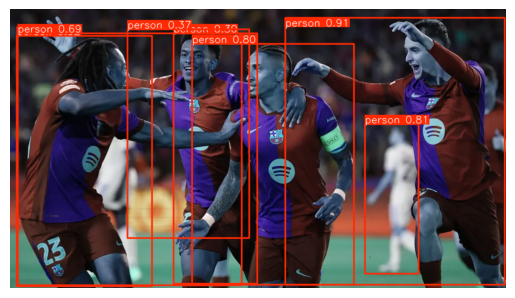

In [9]:
# Obtener la imagen con las detecciones
img_result = results[0].plot()

# Mostrar la imagen
plt.figure()
plt.imshow(img_result)
plt.axis('off')  # Ocultar los ejes
plt.show()

#### Exercici

Carrega una foto emprant la llibreria OpenCV (_cv2_) o la llibreria PIL, fes una predicció i mostra les caixes que envolten els objectes detectats.

### Entrenament

Per realitzar l'entrenament s'empra el mètode `train` de la classe `YOLO`. No s'ha de realitzar cap bucle d'entrenament, sino que aquesta funció ens proporciona un nivell d'abstracció superior. És necessari especificar que aquest mètode és altament parametritzable i es fa necessari un estudi del mateix abans d'iniciar un entrenament.

Consulta la documentació [enllaç](https://docs.ultralytics.com/modes/train/#key-features-of-train-mode)

In [10]:
## Copiat de la documentació oficial
from ultralytics import YOLO

# Load a COCO-pretrained YOLO model
model = YOLO("yolov5n.pt") # també es pot carregar un model sense pre entrenar. Es troben en fitxers .yaml

# Train the model on the COCO8 example dataset for 100 epochs
results = model.train(data="coco8.yaml", epochs=100, imgsz=640) #NOTA: Aquí podem entrenar ja que coco8 "es troba dins ultralytics"

# Run inference
results = model("path/to/imatge.jpg")

PRO TIP  Replace 'model=yolov5n.pt' with new 'model=yolov5nu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

Ultralytics 8.3.38  Python-3.12.5 torch-2.4.1 CPU (11th Gen Intel Core(TM) i7-1185G7 3.00GHz)
engine\trainer: task=detect, mode=train, model=yolov5n.pt, data=coco8.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_s

100%|██████████| 433k/433k [00:00<00:00, 6.77MB/s]
Unzipping C:\Users\PepBiel\Documents\GitHub\Practiques_Aprenentatge_Automatic\14_YOLO\datasets\coco8.zip to C:\Users\PepBiel\Documents\GitHub\Practiques_Aprenentatge_Automatic\14_YOLO\datasets\coco8...: 100%|██████████| 25/25 [00:00<00:00, 1255.16file/s]

Dataset download success  (1.2s), saved to C:\Users\PepBiel\Documents\GitHub\Practiques_Aprenentatge_Automatic\14_YOLO\datasets



100%|██████████| 755k/755k [00:00<00:00, 7.42MB/s]


                   from  n    params  module                                       arguments                     
  0                  -1  1      1760  ultralytics.nn.modules.conv.Conv             [3, 16, 6, 2, 2]              
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      4800  ultralytics.nn.modules.block.C3              [32, 32, 1]                   
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     29184  ultralytics.nn.modules.block.C3              [64, 64, 2]                   
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  3    156928  ultralytics.nn.modules.block.C3              [128, 128, 3]                 
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

YOLOv5n summary: 262 layers, 2,654,816 parameters, 2,654,800 gradients, 7.8 GFLOPs

Transferred 427/427 items from pretrained weights
Freezing layer 'model.24.dfl.conv.weight'


train: Scanning C:\Users\PepBiel\Documents\GitHub\Practiques_Aprenentatge_Automatic\14_YOLO\datasets\coco8\labels\train... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<00:00, 899.10it/s]

train: New cache created: C:\Users\PepBiel\Documents\GitHub\Practiques_Aprenentatge_Automatic\14_YOLO\datasets\coco8\labels\train.cache



val: Scanning C:\Users\PepBiel\Documents\GitHub\Practiques_Aprenentatge_Automatic\14_YOLO\datasets\coco8\labels\val... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<00:00, 1685.64it/s]

val: New cache created: C:\Users\PepBiel\Documents\GitHub\Practiques_Aprenentatge_Automatic\14_YOLO\datasets\coco8\labels\val.cache


Plotting labels to runs\detect\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G       1.41      2.876      1.754         22        640: 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]

                   all          4         17      0.786      0.667      0.903      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G       1.32      2.709      1.542         23        640: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]

                   all          4         17      0.783      0.667      0.904      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100         0G      1.122      3.326      1.466         16        640: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]

                   all          4         17      0.785      0.667      0.904      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100         0G      1.356      2.785      1.481         35        640: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

                   all          4         17      0.802      0.683      0.927      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G      1.568      3.255      1.726         25        640: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all          4         17      0.783      0.667        0.9      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100         0G      1.782      4.315      2.094         31        640: 100%|██████████| 1/1 [00:02<00:00,  2.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]

                   all          4         17       0.77      0.667      0.901      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100         0G      1.299      2.234      1.499         25        640: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

                   all          4         17      0.772      0.667      0.901      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100         0G      1.465      2.956      1.702         14        640: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

                   all          4         17      0.773      0.667      0.901      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100         0G      1.162      2.875      1.484         36        640: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

                   all          4         17      0.753      0.667      0.902      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100         0G      1.398      3.576      1.811         27        640: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

                   all          4         17      0.735      0.667      0.903      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100         0G      1.554      3.146      1.704         29        640: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

                   all          4         17      0.664      0.758      0.931      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100         0G      0.954      1.905       1.43         21        640: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

                   all          4         17      0.663      0.758      0.931      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100         0G       1.13      2.647       1.35         40        640: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

                   all          4         17      0.657      0.755      0.931      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100         0G      1.281      2.799      1.704         14        640: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

                   all          4         17      0.661      0.747      0.931      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100         0G     0.8733      1.515      1.131         32        640: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

                   all          4         17      0.666      0.742      0.931      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100         0G      1.226      2.771      1.602         28        640: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

                   all          4         17      0.596      0.926      0.931      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100         0G     0.8827      2.214      1.207         26        640: 100%|██████████| 1/1 [00:01<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

                   all          4         17      0.611      0.912      0.931      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100         0G      1.175       1.84      1.296         33        640: 100%|██████████| 1/1 [00:02<00:00,  2.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

                   all          4         17      0.611      0.912      0.931      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100         0G       1.13      2.081      1.304         42        640: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

                   all          4         17      0.617      0.872       0.93      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100         0G     0.9779      1.756      1.312         18        640: 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

                   all          4         17      0.617      0.872       0.93      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100         0G       1.42      2.661      1.848         16        640: 100%|██████████| 1/1 [00:01<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all          4         17       0.63      0.767       0.93      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100         0G      1.335      2.545        1.7         29        640: 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all          4         17       0.63      0.767       0.93      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100         0G      1.116      2.148      1.533         27        640: 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

                   all          4         17      0.645      0.767       0.93      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100         0G      1.291      2.441      1.664         20        640: 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all          4         17      0.645      0.767       0.93      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100         0G     0.9505      1.714      1.322         27        640: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all          4         17      0.641      0.767      0.808       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100         0G      1.024      1.869      1.441         28        640: 100%|██████████| 1/1 [00:01<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

                   all          4         17      0.641      0.767      0.808       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100         0G       1.07       2.03       1.59         24        640: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all          4         17      0.682        0.6      0.809       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100         0G     0.9591      1.489      1.299         34        640: 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

                   all          4         17      0.682        0.6      0.809       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100         0G      1.057      1.692      1.333         36        640: 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all          4         17      0.674        0.6      0.809       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100         0G      1.338      2.436      1.626         33        640: 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

                   all          4         17      0.674        0.6      0.809       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100         0G      1.155      1.647      1.415         44        640: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all          4         17      0.907      0.411      0.809      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100         0G      0.996      1.485      1.392         22        640: 100%|██████████| 1/1 [00:01<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

                   all          4         17      0.907      0.411      0.809      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100         0G      0.888      1.343      1.443         10        640: 100%|██████████| 1/1 [00:01<00:00,  1.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all          4         17      0.903       0.41       0.81      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100         0G      1.016       1.33      1.302         33        640: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

                   all          4         17      0.903       0.41       0.81      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100         0G      1.018      2.727      1.415         32        640: 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

                   all          4         17      0.904       0.41       0.81      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100         0G     0.9592      1.771      1.251         29        640: 100%|██████████| 1/1 [00:01<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

                   all          4         17      0.904       0.41       0.81      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100         0G     0.9952      1.468      1.367         24        640: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

                   all          4         17        0.9       0.41      0.811      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100         0G     0.6689     0.7985      1.071         16        640: 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all          4         17        0.9       0.41      0.811      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100         0G     0.6305      1.183      1.078         18        640: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

                   all          4         17      0.897       0.41      0.812      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100         0G     0.9645     0.9613      1.256         26        640: 100%|██████████| 1/1 [00:03<00:00,  3.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

                   all          4         17      0.897       0.41      0.812      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100         0G     0.6762     0.8505      1.034         23        640: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

                   all          4         17      0.894       0.41       0.73      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100         0G     0.9429      1.718      1.359         13        640: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all          4         17      0.894       0.41       0.73      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100         0G     0.9423      1.424      1.287         31        640: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all          4         17      0.891       0.41      0.652      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100         0G      1.159      1.187      1.496         23        640: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all          4         17      0.891       0.41      0.652      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100         0G      0.702      1.062       1.09         31        640: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all          4         17      0.888      0.411      0.633      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100         0G     0.8303      1.121      1.315         32        640: 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

                   all          4         17      0.888      0.411      0.633      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100         0G     0.8736      1.968      1.298         23        640: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

                   all          4         17      0.885      0.413      0.723      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100         0G     0.9198      1.682      1.296         36        640: 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all          4         17      0.885      0.413      0.723      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100         0G     0.7629      1.009        1.3         15        640: 100%|██████████| 1/1 [00:01<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all          4         17      0.883      0.415      0.696      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100         0G     0.8846      1.004      1.314         24        640: 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all          4         17      0.883      0.415      0.696      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100         0G     0.9054      1.001      1.206         32        640: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

                   all          4         17      0.881      0.416      0.695      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100         0G      1.091      1.037      1.439         16        640: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

                   all          4         17      0.881      0.416      0.695      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100         0G     0.6045     0.8186      1.171         20        640: 100%|██████████| 1/1 [00:01<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]

                   all          4         17      0.881      0.416      0.695      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100         0G     0.8407     0.9974      1.291         32        640: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all          4         17      0.876      0.417      0.699      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100         0G     0.7326      1.039      1.079         26        640: 100%|██████████| 1/1 [00:02<00:00,  2.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

                   all          4         17      0.876      0.417      0.699      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100         0G      1.182        2.1      1.686         13        640: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all          4         17      0.876      0.417      0.699      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100         0G      1.054      1.905      1.397         23        640: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

                   all          4         17      0.874      0.417      0.699      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100         0G      1.091      1.807       1.47         46        640: 100%|██████████| 1/1 [00:01<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

                   all          4         17      0.874      0.417      0.699      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100         0G     0.9578     0.9641      1.315         32        640: 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

                   all          4         17      0.874      0.417      0.699      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100         0G      1.139      1.108      1.596         14        640: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all          4         17      0.872      0.417      0.698      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100         0G      0.756     0.9101      1.155         34        640: 100%|██████████| 1/1 [00:01<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

                   all          4         17      0.872      0.417      0.698      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100         0G      0.855      1.169      1.168         49        640: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all          4         17      0.872      0.417      0.698      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100         0G     0.8184      1.117      1.232         28        640: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all          4         17      0.871      0.417      0.686      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100         0G     0.7564     0.7611      1.196         30        640: 100%|██████████| 1/1 [00:01<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all          4         17      0.871      0.417      0.686      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100         0G     0.7721     0.9269      1.325         19        640: 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

                   all          4         17      0.871      0.417      0.686      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100         0G     0.7508      1.267       1.15         18        640: 100%|██████████| 1/1 [00:02<00:00,  2.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

                   all          4         17      0.869      0.417      0.688      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100         0G     0.8366      1.222      1.196         60        640: 100%|██████████| 1/1 [00:02<00:00,  2.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

                   all          4         17      0.869      0.417      0.688      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100         0G      1.168      2.133      1.588         31        640: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all          4         17      0.869      0.417      0.688      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100         0G     0.7215      1.123      1.195         32        640: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

                   all          4         17      0.871      0.417        0.7      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100         0G     0.9807     0.9304      1.438         22        640: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

                   all          4         17      0.871      0.417        0.7      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100         0G       1.01      1.382      1.368         33        640: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all          4         17      0.871      0.417        0.7      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100         0G     0.6919     0.7332      1.183         32        640: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

                   all          4         17      0.874      0.417        0.7      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100         0G     0.7518       1.13       1.12         38        640: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all          4         17      0.874      0.417        0.7      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100         0G     0.8103     0.8268      1.322         13        640: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all          4         17      0.874      0.417        0.7      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100         0G     0.7848     0.6858      1.192         25        640: 100%|██████████| 1/1 [00:02<00:00,  2.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all          4         17      0.872      0.417      0.701      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100         0G     0.8215      1.011      1.304         27        640: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all          4         17      0.872      0.417      0.701      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100         0G     0.7455     0.7614       1.17         32        640: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

                   all          4         17      0.872      0.417      0.701      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100         0G     0.8655      1.306      1.203         44        640: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

                   all          4         17      0.872      0.417      0.619      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100         0G     0.6865      1.036      1.178         18        640: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

                   all          4         17      0.872      0.417      0.619      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100         0G     0.7527      1.002      1.215         22        640: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

                   all          4         17      0.872      0.417      0.619      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100         0G     0.5382     0.5864      1.014         35        640: 100%|██████████| 1/1 [00:02<00:00,  2.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

                   all          4         17      0.874      0.417      0.591      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100         0G     0.8806     0.8084      1.211         37        640: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

                   all          4         17      0.874      0.417      0.591      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100         0G     0.7934     0.9205      1.196         45        640: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

                   all          4         17      0.874      0.417      0.591      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100         0G     0.7571     0.8192      1.136         27        640: 100%|██████████| 1/1 [00:02<00:00,  2.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

                   all          4         17      0.849        0.4      0.591      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100         0G     0.6985      0.831      1.198         20        640: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]

                   all          4         17      0.849        0.4      0.591      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100         0G     0.7604      1.172      1.143         20        640: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

                   all          4         17      0.849        0.4      0.591      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100         0G     0.7684     0.8863      1.091         22        640: 100%|██████████| 1/1 [00:01<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

                   all          4         17      0.849        0.4      0.591      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100         0G     0.8411      1.154      1.413         23        640: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all          4         17      0.845      0.409      0.584      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100         0G      1.112      1.238      1.526         19        640: 100%|██████████| 1/1 [00:01<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

                   all          4         17      0.845      0.409      0.584      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100         0G     0.7348     0.8517      1.067         39        640: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all          4         17      0.845      0.409      0.584      0.367


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100         0G     0.5568     0.7782      1.008         13        640: 100%|██████████| 1/1 [00:01<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

                   all          4         17      0.845      0.409      0.584      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100         0G     0.7687     0.8663     0.9858         13        640: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all          4         17      0.967      0.352      0.697      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100         0G     0.6244     0.7246      1.081         13        640: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

                   all          4         17      0.967      0.352      0.697      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100         0G     0.6128     0.7345     0.9543         13        640: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

                   all          4         17      0.967      0.352      0.697      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100         0G     0.4783     0.6629     0.9741         13        640: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

                   all          4         17      0.967      0.352      0.697      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100         0G       0.63     0.7851      1.098         13        640: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

                   all          4         17      0.968      0.352      0.699      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100         0G     0.7495     0.8305      1.083         13        640: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

                   all          4         17      0.968      0.352      0.699      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100         0G     0.6588     0.7331     0.9998         13        640: 100%|██████████| 1/1 [00:02<00:00,  2.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

                   all          4         17      0.968      0.352      0.699      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100         0G     0.6042     0.7866      1.003         13        640: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

                   all          4         17      0.968      0.352      0.699      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100         0G     0.6016     0.7127      1.042         13        640: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

                   all          4         17      0.966      0.352      0.769      0.407



100 epochs completed in 0.087 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 5.6MB
Optimizer stripped from runs\detect\train\weights\best.pt, 5.6MB

Validating runs\detect\train\weights\best.pt...
Ultralytics 8.3.38  Python-3.12.5 torch-2.4.1 CPU (11th Gen Intel Core(TM) i7-1185G7 3.00GHz)
YOLOv5n summary (fused): 193 layers, 2,649,200 parameters, 0 gradients, 7.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]


                   all          4         17      0.801      0.683      0.927      0.639
                person          3         10      0.791        0.5      0.586        0.3
                   dog          1          1          1          0      0.995      0.796
                 horse          1          2      0.761          1      0.995      0.697
              elephant          1          2          1      0.599      0.995      0.352
              umbrella          1          1      0.544          1      0.995      0.796
          potted plant          1          1      0.713          1      0.995      0.895
Speed: 1.5ms preprocess, 119.0ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs\detect\train



FileNotFoundError: path/to/imatge.jpg does not exist

### Segmentació amb YOLO

Encara que modificant la versió 5 es poden realitzar tasques de segmentació (veure [enllaç](https://github.com/ultralytics/yolov5/blob/master/segment/tutorial.ipynb)), és a partir de la versió 8 que aquesta tasca s'integra dins la xarxa amb l'incorporació d'un nou cap per aquesta tasca.

A la documentació podem veure com ja tenim versions de tots els fitxers amb pesos per les diferents tasques: [enllaç](https://docs.ultralytics.com/models/yolov8/#supported-tasks-and-modes).

A continuació veurem un exemple de segmentació:

In [ ]:
from ultralytics import YOLO

# Load a COCO-pretrained YOLOv8n model
model = YOLO("yolov8n-seg.pt")

results_seg = model(img)

In [ ]:
img_result = results_seg[0].plot()

plt.figure()
plt.imshow(img_result);
plt.show();

#### Exercici

En la imatge anterior tenim tant les capses de detecció com les segmentacions:
1. Es demana que mostreu només la segmentació de la persona amb major valor de confiança de la xarxa.
2. Es demana que mostreu per pantalla les coordenades de la capsa de detecció de la corbata.